In [95]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize, curve_fit
import astropy.units as u
import astropy.constants as const
import math
from math import pi
import sympy
import statistics
from scipy.special import fresnel
from scipy.stats import linregress, pearsonr
from astropy.cosmology import WMAP9 as cosmo
import matplotlib.pyplot as plt
import matplotlib.cm
import scipy.signal as signal
from scipy import integrate
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import (ListedColormap, LinearSegmentedColormap)

$$I_{p}(x') =I_0 \frac{1}{2}\left[\left(\frac{1}{2} + C \left[\sqrt{\frac{2}{\lambda z_0}}x'\right]\right)^2 + \left(\frac{1}{2} + S \left[\sqrt{\frac{2}{\lambda z_0}}x'\right]\right)^2\right]$$

$$C(x) = \int_{0}^x \cos{\left(\frac{\pi}{2}t^2\right)}dt \hspace{5mm} S(x) = \int_{0}^x \sin{\left(\frac{\pi}{2}t^2\right)}dt$$

In [96]:
i_0 = (1000 * u.mW).to(u.W).value
wavelength = (650 * u.nm).to(u.m).value
z_0 = (6.5 * u.cm).to(u.m).value

In [97]:
def i_p(x_prime, wavelength, i_0, z_0):
    
    fresnel_s, fresnel_c = fresnel(np.sqrt(2 / (wavelength * z_0)) * x_prime)
    c_parameter = (1/2) + fresnel_c
    s_parameter = (1/2) + fresnel_s
    return i_0 * (1/2) * (c_parameter**2 + s_parameter**2)

In [98]:
x_prime_array = np.linspace(-0.001, 0.001, 2500)

teorica = pd.DataFrame()
teorica['x_prime'] = x_prime_array
teorica['i_p'] = i_p(x_prime_array, wavelength, i_0, z_0)

In [99]:
noise = pd.read_csv(os.path.join('DATOS', 'noise.csv'), sep=',')

In [100]:
mean_noise = np.mean(noise['Gray_Value'])
mean_noise

9.473132468085105

In [200]:
x_prime_array = np.linspace(0, 0.00215, 2500)
teorica = pd.DataFrame()
teorica['x_prime'] = x_prime_array
teorica['i_p'] = i_p(x_prime_array, wavelength, i_0, z_0)

In [270]:
def fit(x, a, b):
    return a * x + b


def read_data_calibrate(path, noise, teorica):
    data = pd.read_csv(path)
    data = data.sort_values(by=['Distance_(pixels)'])
    
    peaks, _ = signal.find_peaks(data['Gray_Value'] - noise, height=0.5, distance=100)
    peak = peaks[-1:][0]
    
    peaks_teo, _ = signal.find_peaks(teorica['i_p'], height=0.00, distance=1)
    peak_teo = peaks_teo[0]
    
    anti_peaks_teo, _ = signal.find_peaks(-teorica['i_p'] + teorica['i_p'][peak_teo], height=0.00)
    anti_peak_teo = anti_peaks_teo[0]
    
    local_minima, _ = signal.find_peaks(-1 * (data['Gray_Value'][0:peak] - noise) + (data['Gray_Value'] - noise)[0], height=-0.1, distance=10)
    minimum = local_minima[-1:][0]
    
    i_0_peak_m, i_0_peak = teorica['x_prime'][peak_teo], teorica['i_p'][peak_teo]
    i_0_antipeak_m, i_0_antipeak = teorica['x_prime'][anti_peak_teo], teorica['i_p'][anti_peak_teo]
    
    data_peak_m, data_peak = data['Distance_(pixels)'][peak], data['Gray_Value'][peak]
    data_antipeak_m, data_antipeak = data['Distance_(pixels)'][minimum], data['Gray_Value'][minimum]
    
    popt_m, pcov_m = curve_fit(fit, [data_peak_m, data_antipeak_m], [i_0_peak_m, i_0_antipeak_m])
    popt2_i, pcov_i = curve_fit(fit, [data_peak, data_antipeak], [i_0_peak, i_0_antipeak])
    
    calibrated_data = pd.DataFrame()
    
    calibrated_data['Distance_(mm)'] = (np.array(fit(data['Distance_(pixels)'], *popt_m)) * u.m).to(u.mm).value
    calibrated_data['Intensity'] = np.array(fit(data['Gray_Value'], *popt2_i))
    
    calibrated_data = calibrated_data.sort_values(by=['Distance_(mm)'], ascending=True)
    
    return calibrated_data.query('`Distance_(mm)` < {} and `Distance_(mm)` > 0'.format(
        (np.array(teorica.sort_values(by=['x_prime'], ascending=True)['x_prime'][-1:]) * u.m)[0].to(u.mm).value
    ))    
    

def calibrate_airy_disk(path, path_disk, noise, teorica):
    data = pd.read_csv(path)
    data = data.sort_values(by=['Distance_(pixels)'])
    
    airy_disk_data = pd.read_csv(path_disk)
    
    peaks, _ = signal.find_peaks(data['Gray_Value'] - noise, height=0.5, distance=100)
    peak = peaks[-1:][0]
    
    peaks_teo, _ = signal.find_peaks(teorica['i_p'], height=0.00, distance=1)
    peak_teo = peaks_teo[0]
    
    anti_peaks_teo, _ = signal.find_peaks(-teorica['i_p'] + teorica['i_p'][peak_teo], height=0.00)
    anti_peak_teo = anti_peaks_teo[0]
    
    local_minima, _ = signal.find_peaks(-1 * (data['Gray_Value'][0:peak] - noise) + (data['Gray_Value'] - noise)[0], height=-0.1, distance=10)
    minimum = local_minima[-1:][0]
    
    i_0_peak_m, i_0_peak = teorica['x_prime'][peak_teo], teorica['i_p'][peak_teo]
    i_0_antipeak_m, i_0_antipeak = teorica['x_prime'][anti_peak_teo], teorica['i_p'][anti_peak_teo]
    
    data_peak_m, data_peak = data['Distance_(pixels)'][peak], data['Gray_Value'][peak]
    data_antipeak_m, data_antipeak = data['Distance_(pixels)'][minimum], data['Gray_Value'][minimum]
    
    popt_m, pcov_m = curve_fit(fit, [data_peak_m, data_antipeak_m], [i_0_peak_m, i_0_antipeak_m])
    popt2_i, pcov_i = curve_fit(fit, [data_peak, data_antipeak], [i_0_peak, i_0_antipeak])
    
    calibrated_airy_disk = pd.DataFrame()
    
    calibrated_airy_disk['Distance_(mm)'] = (np.array(fit(airy_disk_data['Distance_(pixels)'], *popt_m)) * u.m).to(u.mm).value
    calibrated_airy_disk['Intensity'] = np.array(fit(airy_disk_data['Gray_Value'], *popt2_i))
    
    calibrated_airy_disk = calibrated_airy_disk.sort_values(by=['Distance_(mm)'], ascending=True)
    
    return calibrated_airy_disk.query('`Distance_(mm)` < {} and `Distance_(mm)` > 0'.format(
        (np.array(teorica.sort_values(by=['x_prime'], ascending=True)['x_prime'][-1:]) * u.m)[0].to(u.mm).value
    ))

In [271]:
airy_disk_data = calibrate_airy_disk(os.path.join('DATOS', 'WIN_20231122_09_18_23_Pro.csv'), os.path.join('DATOS', 'airy_disk.csv'), mean_noise, teorica)

c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [104]:
plt.rcParams.update({
    'text.usetex': False,
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.family': 'serif',
    'font.weight': 'normal'
})

In [256]:
calibrated_data = read_data_calibrate(os.path.join('DATOS', 'WIN_20231122_09_18_23_Pro.csv'), mean_noise, teorica)
calibrated_data_1 = read_data_calibrate(os.path.join('DATOS', 'WIN_20231122_09_05_42_Pro.csv'), mean_noise, teorica)
calibrated_data_2 = read_data_calibrate(os.path.join('DATOS', 'WIN_20231122_09_05_25_Pro.csv'), mean_noise, teorica)

c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


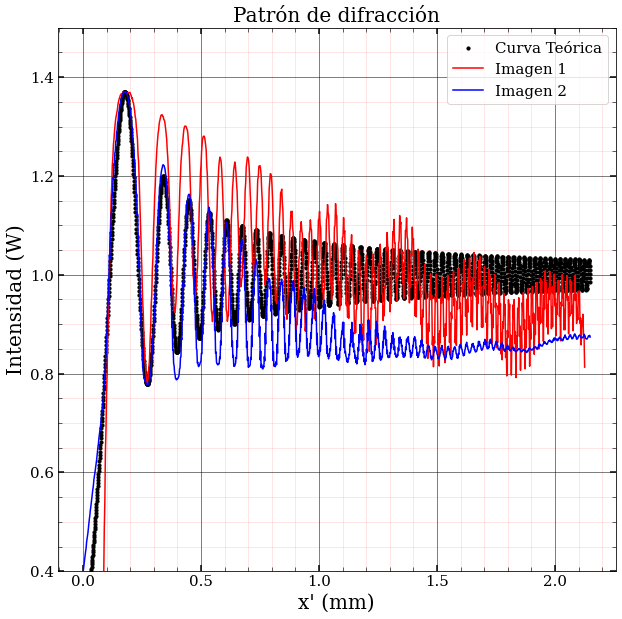

In [278]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter((x_prime_array * u.m).to(u.mm), i_p(x_prime_array, wavelength, i_0, z_0), color='black', s=10, label='Curva Teórica')
ax.plot(calibrated_data['Distance_(mm)'], calibrated_data['Intensity'], color='red', label='Imagen 1')
ax.plot(calibrated_data_1['Distance_(mm)'], calibrated_data_1['Intensity'], color='blue', label='Imagen 2')

ax.set_ylim(0.4, 1.5)

ax.set_ylabel(r'Intensidad (W)', fontsize=20)
ax.set_xlabel(r"x' (mm)", fontsize=20)
ax.set_title('Patrón de difracción', fontsize=20)

ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax.grid(True, which='both')
ax.legend(fontsize=15, markerscale=1)

In [232]:
# Create a common set of distances
common_distances = np.union1d(calibrated_data['Distance_(mm)'], calibrated_data_1['Distance_(mm)'])

# Interpolate values for the common distances in both dataframes
calibrated_data_interpolated = pd.DataFrame({'Distance_(mm)': common_distances})
calibrated_data_interpolated['Intensity'] = np.interp(common_distances, calibrated_data['Distance_(mm)'], calibrated_data['Intensity'])

calibrated_data_1_interpolated = pd.DataFrame({'Distance_(mm)': common_distances})
calibrated_data_1_interpolated['Intensity'] = np.interp(common_distances, calibrated_data_1['Distance_(mm)'], calibrated_data_1['Intensity'])


In [257]:
calibrated_data_2_interpolated = pd.DataFrame({'Distance_(mm)': common_distances})
calibrated_data_2_interpolated['Intensity'] = np.interp(common_distances, calibrated_data_2['Distance_(mm)'], calibrated_data_2['Intensity'])


In [233]:
calibrated_data_interpolated

,Distance_(mm),Intensity
0,0.000088,-0.570251
1,0.001475,-0.558827
2,0.002515,-0.550259
3,0.003406,-0.542625
4,0.004941,-0.529477
...,...,...
1984,2.141449,0.813089
1985,2.143381,0.813089
1986,2.145312,0.813089
1987,2.147243,0.813089


In [234]:
calibrated_data_1_interpolated

,Distance_(mm),Intensity
0,0.000088,0.403295
1,0.001475,0.403295
2,0.002515,0.407237
3,0.003406,0.410617
4,0.004941,0.417455
...,...,...
1984,2.141449,0.875623
1985,2.143381,0.876410
1986,2.145312,0.875509
1987,2.147243,0.877358


In [258]:
mean_data = pd.DataFrame({'Distance_(mm)': calibrated_data_interpolated['Distance_(mm)']})
mean_data['Intensity'] = (calibrated_data_interpolated['Intensity'] +
                          calibrated_data_1_interpolated['Intensity'] +
                          calibrated_data_2_interpolated['Intensity']) / 3
mean_data

,Distance_(mm),Intensity
0,0.000088,-0.370102
1,0.001475,-0.366294
2,0.002515,-0.362124
3,0.003406,-0.358453
4,0.004941,-0.351791
...,...,...
1984,2.141449,0.823450
1985,2.143381,0.823713
1986,2.145312,0.823412
1987,2.147243,0.824029


In [267]:
airy_disk_data = pd.read_csv(os.path.join('DATOS', 'airy_disk.csv'), sep=',')
airy_disk_data

,Distance_(pixels),Gray_Value
0,0,193.690
1,1,195.179
2,2,196.809
3,3,199.442
4,4,200.523
...,...,...
491,491,80.485
492,492,80.752
493,493,79.994
494,494,79.623


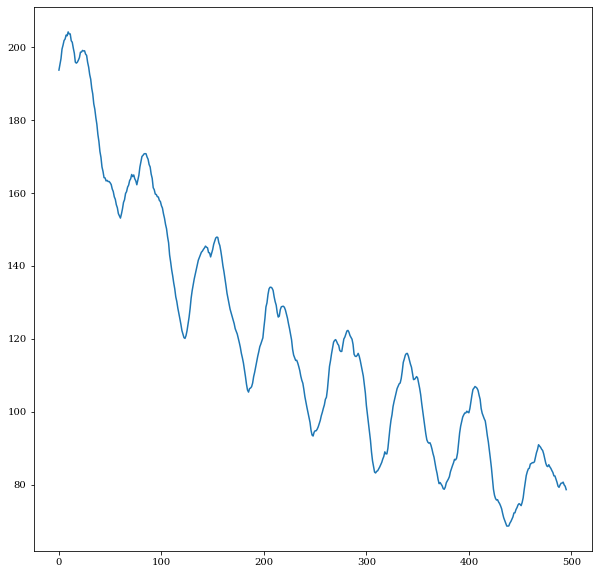

In [269]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(airy_disk_data['Distance_(pixels)'], airy_disk_data['Gray_Value'])